# Extracting Additional Features and Fitting Models
We have already worked with an ensemble of neural networks to model the settle price of EU ETS certificates. Next, we will use models that rely on the sample size to a smaller degree. Since neural networks are basically general function approximators, they can tune their intern parameters to closely match a function given only a sufficiently large sample. Other models are not necessarily as flexible but also have fewer degrees of freedom, thus requiring less input data for a reasonable fit. For this reason, we will spend some time extracting relevant features from the data.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os
import preprocessing.numerical_data as pnd
sns.set_style("darkgrid")

In [2]:
df = pd.read_csv(os.path.join("data", "raw", "input.csv"), sep=";", index_col=0, parse_dates=[0], dtype=np.float64)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 994 entries, 2018-11-07 to 2015-01-02
Data columns (total 25 columns):
Open                       988 non-null float64
High                       988 non-null float64
Low                        988 non-null float64
Settle                     994 non-null float64
Change                     984 non-null float64
Volume                     988 non-null float64
Prev. Day Open Interest    993 non-null float64
Gas.Open                   990 non-null float64
Gas.High                   990 non-null float64
Gas.Low                    990 non-null float64
Gas.Settle                 994 non-null float64
Gas.Change                 984 non-null float64
Gas.Volume                 984 non-null float64
Coal.Open                  994 non-null float64
Coal.High                  994 non-null float64
Coal.Low                   994 non-null float64
Coal.Settle                994 non-null float64
Coal.Change                994 non-null float64
Coal.Volume 

### Extracting Seasonal Features
We start by extracting features for the difference in days relative to a baseline, say, 2015-01-01, as well as information about the day of week and the month.

In [3]:
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
df["Days.Since"] = (df.index - pd.datetime.strptime("2015-01-01", "%Y-%m-%d")).days
df["Weekday"] = list(map(pd.datetime.weekday, df.index))
df["Weekday.String"] = df["Weekday"].replace({i: day for i, day in enumerate(weekdays)})
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November",
         "December"]
df["Month"] = list(map(lambda x: x.month, df.index))
df["Month.String"] = df["Month"].replace({i+1: month for i, month in enumerate(months)})

Let us now plot the data to look for associations. We will make boxplots to compare the average change of settle price (i.e. the difference between the settle price at time $t+1$ minus the settle price at time $t$) within each of the groups (i.e. for each weekday or for each month).

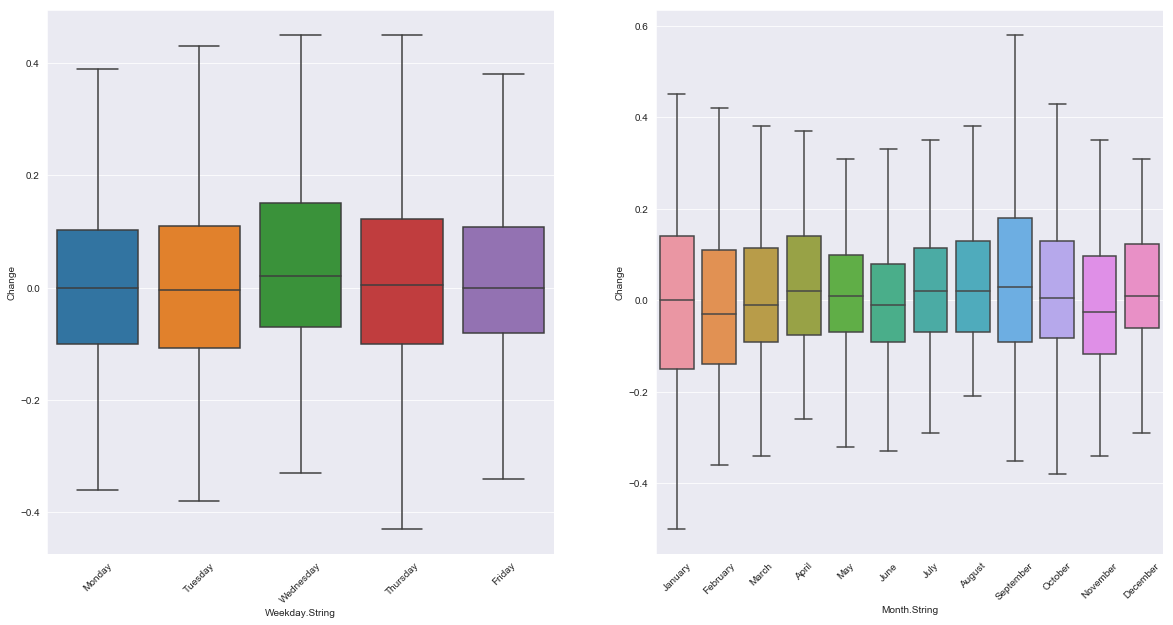

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.boxplot(df["Weekday.String"], df["Change"], showfliers=False, order=weekdays, ax=axes[0])
sns.boxplot(df["Month.String"], df["Change"], showfliers=False, order=months, ax=axes[1])
for i in range(2):
    _ = axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

There seems to be a slight seasonal trend in the data in the sense that changes from tuesday to wednesday are, on average, more positive and that that average monthly changes are periodic. Consequently, we might choose to include them in our model.
Next, we will convert them to dummy variables.

In [5]:
df = pd.concat([df,
           pd.get_dummies(df["Weekday"]).rename(columns={i: "Weekday." + day for i, day in enumerate(weekdays)}),
           pd.get_dummies(df["Month"]).rename(columns={i+1: "Month." + month for i, month in enumerate(months)})], axis=1)

### Performing Further Preprocessing Steps
We will now apply the steps from the EDA notebook and log the prices.

In [6]:
df = pnd.chain_preparations(df)
df = pnd.log_prices(df)
df["Settle.To.Open"] = df["Open"] - df["Prev. Day Settle"]

Since the number of features is quite large relative to the number of observations, we might run into problems with overfitting. As a countermeasure, we can try and reduce the dimensionality of the problem. We will do so by applying the singular value decomposition (SVD) and keeping only some number of principal components. First, we will explore hoch much of the variance is captured in each of the principal components:

In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA().fit(StandardScaler().fit_transform(df.drop(["Change", "Month.String", "Weekday.String"], axis=1).values))
print(np.cumsum(pca.explained_variance_ratio_))

[0.28188477 0.35716413 0.42007414 0.46927321 0.5069775  0.54131203
 0.57363741 0.6049808  0.6340025  0.66156532 0.68886931 0.71532382
 0.7410479  0.76543212 0.78954681 0.81348404 0.83729974 0.86076409
 0.88294724 0.90289627 0.92183386 0.93863995 0.95325172 0.96675551
 0.97793585 0.98652926 0.99285487 0.99833531 0.99934024 0.99974717
 0.99981741 0.99985948 0.99989186 0.9999224  0.99994622 0.99996528
 0.99997629 0.99998492 0.99999168 0.99999755 1.         1.
 1.         1.         1.         1.        ]


As we can see, the last 20 principal components contain less than 1% of the total variance in the data. Considering the heavy correlation in the data set (as seen in the EDA notebook), this is not surprising. Since the singular vectors as obtained by the SVD are orthogonal, the resulting input vectors are uncorrelated.

It might be beneficial to include some kind of history in the predictors to deal with the temporal component of regression problem. To do so, will add features corresponding to the last 10 days. Afterwards, we have to discard the first 10 rows.

In [8]:
NUM_DAYS = 10
pnd.add_prev_values(df, NUM_DAYS, ("Change",))
df = df.loc[df.index[10:]]

### Fitting Models
We will continue the analysis with fitting a few models to the data with the additional features. For this step, we will build several pipelines that contain scaling steps, possibly the principal component analysis (PCA) or SVD and a regressor. Since we are working with time series data, we need to be careful to avoid data leaks. In particular, we have to use a cross validation splitter that is optimized for time series so that the training data corresponds to the past and the validation data corresponds to the future.

In [93]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit

seed = 123
np.random.seed(seed)

y = df["Change"].values
X = df.drop(["Change", "Month.String", "Weekday.String"], axis=1).values
column_names = df.drop(["Change", "Month.String", "Weekday.String"], axis=1).columns
date_index = df.index

train_indices = np.arange(int(len(X) * 0.8))
test_indices = np.arange(int(len(X) * 0.8), len(X))

X_train, X_test, y_train, y_test, index_train, index_test = (X[train_indices], X[test_indices], y[train_indices],
y[test_indices], date_index[train_indices], date_index[test_indices])
tscv = TimeSeriesSplit(n_splits=5, max_train_size=180)

First, we will fit a random forest with grid search cross validation. We will use a standard scaler to center our data around mean 0 and to scale the data to unit variance. Since random forests do well with high dimensional features, we will not do PCA here.

In [18]:
%%time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

rf_pipe = Pipeline([("scaler", StandardScaler()), 
                    ("rf", RandomForestRegressor(n_jobs=-1, random_state=123))])
rf_model = GridSearchCV(rf_pipe, param_grid={"rf__n_estimators": [100, 150, 200, 500],
                                             "rf__max_depth": [None, 2, 3, 5, 10, 20],},
                       cv=tscv, scoring="neg_mean_squared_error", iid=False)
rf_model.fit(X_train, y_train)
print(rf_model.best_params_)

{'rf__max_depth': 2, 'rf__n_estimators': 200}
Wall time: 57.3 s


Having selected the best model, it is time to evaluate the model performance on the held back validation data. Note that the validation data is from the future relative to the training data due to the initial split earlier. This way, we take care of potential data leaks.

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
rf_model_training_error = mean_squared_error(y_train, rf_model.predict(X_train))
rf_model_test_error = mean_squared_error(y_test, rf_model.predict(X_test))
print("Training Set Error", rf_model_training_error)
print("Test Set Error", rf_model_test_error)

Training Set Error 0.023238892869667155
Test Set Error 0.35921103743444704


The model appears to overfit the data. However, recalling the distribution of the errors in the naive approach, we observe a similar phenomenon here.

c:\program files\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


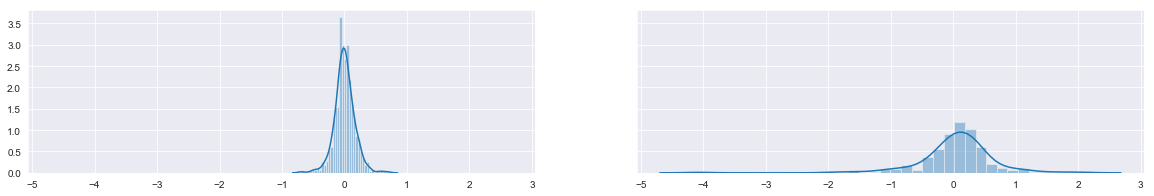

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(20, 3))
for i, y_ in enumerate((y_train, y_test)):
    sns.distplot(y_, ax=axes[i])

The above graph shows what is happening. The values of "Change" have different ranges. The random forest can only predict values that are within its training data response range. An obvious way to fix this would be to just use a scaler like a MinMaxScaler. However, the issue with this is the danger of a data leak. A less problematic approach would be to try and capture a trend with a linear model, e.g. linear regression and to use an ensemble. For now, we will try different estimators and come back later with potential fixes to this issue.
To validate or model, we will use rolling estimations on nested subsets of the data set. This is leave one out cross validation for time series.

In [36]:
%%time
def get_one_day_ahead_diffs(model):
    diffs = []
    for i in range(len(X_train), len(X)):
        model.fit(X[:i], y[:i])
        diffs.append((model.predict(X[i].reshape(1, -1)) - y[i].reshape(1, 1))[0][0])
    return diffs

rf_diffs = get_one_day_ahead_diffs(rf_model.estimator)

Wall time: 41.4 s


Now, let us look at the actual cross validation error:

In [38]:
print("Cross validation MSE", np.square(rf_diffs).mean())

Cross validation MSE 0.4007615958549225


The model is worse than the naive baseline model that only predicts the previous "Settle" value. Considering the fact that the distribution of the responses differs wildly across training in tests data, this is was to be expected. Next, we will use a support vector regressor for estimation.

In [40]:
from sklearn.svm import SVR

svr_pipe = Pipeline([("scaler", StandardScaler()), 
                    ("svr", SVR(gamma="auto"))])
svr_model = GridSearchCV(svr_pipe, param_grid={"svr__kernel": ["poly", "rbf"],
                                              "svr__degree": [1, 2, 3],
                                             "svr__C": [0.0001, 0.001, 0.01, 0.1, 1.0, 10],
                                             "svr__epsilon": [0.01, 0.05, 0.1, 0.5]},
                       cv=tscv, n_jobs=-1, verbose=10)
svr_model.fit(X_train, y_train)
print(svr_model.best_params_)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0219s.) Setting batch_size=18.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1753s.) Setting batch_size=40.
[Parallel(n_jobs=-1)]: Done 178 tasks      | elapsed:    0.4s


{'svr__C': 0.001, 'svr__degree': 2, 'svr__epsilon': 0.1, 'svr__kernel': 'poly'}


[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:    1.1s finished


In [41]:
print("Train MSE:", -np.mean(cross_val_score(svr_model.estimator, X_train, y_train, cv=tscv, n_jobs=-1,
                                            scoring="neg_mean_squared_error")))
print("Test MSE:", -np.mean(cross_val_score(svr_model.estimator, X_test, y_test, cv=tscv, n_jobs=-1,
                                            scoring="neg_mean_squared_error")))

Train MSE: 0.03321989665835323
Test MSE: 0.4368422708631706


Again, we will fit the model on all previous data and use this for next day prediction.

In [42]:
%%time
svr_diffs = get_one_day_ahead_diffs(svr_model.estimator)

print("Cross Validation MSE", np.square(svr_diffs).mean())

Cross Validation MSE 0.36308275659554384
Wall time: 8.61 s


The SVR performs a little better than the random forest. Interestingly, the grid search concluded that a linear kernel function was the best in terms of predictive power. However, we should try and reduce the dimensionality of our feature space by using the PCA (or SVD). Next, we will include this step in our pipeline.

In [43]:
%%time
from joblib import Memory

cachedir = "./tmp/"
memory = Memory(location=cachedir, verbose=0)

svr_pca_pipe = Pipeline([("scaler", StandardScaler()),
                         ("pca", PCA()),
                         ("svr", SVR(gamma="auto", cache_size=500.0))],
                       memory=memory)
svr_pca_model = GridSearchCV(svr_pca_pipe, param_grid={"pca__n_components": [None, 1, 2, 3, 5, 10],
                                                       "svr__kernel": ["poly", "rbf"],
                                                       "svr__degree": [1, 2, 3],
                                                       "svr__C": [0.001, 0.01, 0.1, 1.0],
                                                       "svr__epsilon": [0.01, 0.05, 0.1, 0.5]},
                       cv=tscv, n_jobs=-1, verbose=10)
svr_pca_model.fit(X_train, y_train)
print(svr_pca_model.best_params_)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1586s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1725s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1446s.) Setting batch_size=10.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 100 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 452 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 602 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed: 

{'pca__n_components': None, 'svr__C': 0.001, 'svr__degree': 2, 'svr__epsilon': 0.1, 'svr__kernel': 'poly'}
Wall time: 26.2 s


[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed:   25.9s finished


In [44]:
from sklearn.model_selection import cross_val_score
print("Train MSE:", -np.mean(cross_val_score(svr_pca_model.estimator, X_train, y_train, cv=tscv, n_jobs=-1,
                                            scoring="neg_mean_squared_error")))
print("Test MSE:", -np.mean(cross_val_score(svr_pca_model.estimator, X_test, y_test, cv=tscv, n_jobs=-1,
                                            scoring="neg_mean_squared_error")))

Train MSE: 0.033219896658353246
Test MSE: 0.43636031671714387


In [45]:
%%time
svr_pca_diffs = get_one_day_ahead_diffs(svr_pca_model.estimator)
print("Cross validation error", np.square(svr_pca_diffs).mean())

Cross validation error 0.3630827565955439
Wall time: 11.8 s


The grid search results show that using only a subset of principal components does not yield a gain in predictive performance and no reduction in overfitting. Still, none of our models could compete with the naive approach of a constant prediction. Next, we will use linear regression. Considering that we are potentially dealing with overfitting, we should include regularization parameters. We will combine both ridge and lasso by choosing and elastic net. Since regularization is sensitive to scaling, we need to scale the data first.

In [82]:
from sklearn.linear_model import ElasticNet

elanet_pipe = Pipeline([("scaler", StandardScaler()), 
                    ("elanet", ElasticNet())])
elanet_model = GridSearchCV(elanet_pipe, param_grid={"elanet__alpha": [0.01, 0.1, 0.2, 0.5, 1.0, 5.0, 10.0],
                                                     "elanet__l1_ratio": np.arange(0, 1.1, 0.1)},
                       cv=tscv, n_jobs=-1, verbose=10)
elanet_model.fit(X_train, y_train)
print(elanet_model.best_params_)

Fitting 5 folds for each of 77 candidates, totalling 385 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0249s.) Setting batch_size=16.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1975s.) Setting batch_size=32.


{'elanet__alpha': 0.1, 'elanet__l1_ratio': 0.4}


[Parallel(n_jobs=-1)]: Done 385 out of 385 | elapsed:    0.7s finished


In [83]:
%%time
elanet_diffs = get_one_day_ahead_diffs(elanet_model.estimator)
print("Cross validation error", np.square(elanet_diffs).mean())

Cross validation error 0.3602502704772305
Wall time: 299 ms


In [101]:
coeffs = elanet_model.best_estimator_.named_steps["elanet"].coef_
print("Columns with coefficient > 0:", column_names[np.arange(0, len(coeffs))[coeffs > 0]])

Columns with coefficient > 0: Index(['Settle.To.Open'], dtype='object')


The elastic net performs close to the naive approach and chooses to ignore all predictors except for the Difference between Settle and Open on consecutive days (by setting their respective weights to 0). We will try and include that PCA in the pipeline to see whether the performance changes.

In [103]:
elanet_pca_pipe = Pipeline([("scaler", StandardScaler()), 
                        ("pca", PCA()),
                    ("elanet", ElasticNet())])
elanet_pca_model = GridSearchCV(elanet_pca_pipe, param_grid={"pca__n_components": [None, 1, 2, 3, 5, 10, 20],
                                                     "elanet__alpha": [0.01, 0.1, 0.2, 0.5, 1.0, 5.0, 10.0],
                                                     "elanet__l1_ratio": np.arange(0, 1.1, 0.1)},
                       cv=tscv, n_jobs=-1, verbose=10)
elanet_pca_model.fit(X_train, y_train)
print(elanet_pca_model.best_params_)

Fitting 5 folds for each of 539 candidates, totalling 2695 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1911s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0738s.) Setting batch_size=10.
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1685s.) Setting batch_size=22.
[Parallel(n_jobs=-1)]: Done 175 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 389 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 719 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 1049 tasks      | elapsed

{'elanet__alpha': 0.2, 'elanet__l1_ratio': 0.7000000000000001, 'pca__n_components': None}


[Parallel(n_jobs=-1)]: Done 2695 out of 2695 | elapsed:    7.4s finished


In [104]:
%%time
elanet_pca_diffs = get_one_day_ahead_diffs(elanet_pca_model.estimator)
print("Cross validation error", np.square(elanet_pca_diffs).mean())

Cross validation error 0.3602502704772305
Wall time: 2.38 s


The model chooses to include all pricipal components. Its performance is approximately equal to the model without using PCA. We will try to find some additional features that help the linear model with its predictions. One possible approach is to look for cycles, e.g. weekly ups and downs. To check for such, we will count the lengths contiguous montononous subsequences of our repsonse.

In [ ]:
# ToDo